**Step 1: Import Libraries**

In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

**Step 2: Load Dataset and Check Info.**

In [2]:
df = pd.read_csv("/kaggle/input/student-stress-monitoring-datasets/StressLevelDataset.csv")
df.head()

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-null   int64
 13  study_load                    110

In [4]:
df.isnull().sum()

anxiety_level                   0
self_esteem                     0
mental_health_history           0
depression                      0
headache                        0
blood_pressure                  0
sleep_quality                   0
breathing_problem               0
noise_level                     0
living_conditions               0
safety                          0
basic_needs                     0
academic_performance            0
study_load                      0
teacher_student_relationship    0
future_career_concerns          0
social_support                  0
peer_pressure                   0
extracurricular_activities      0
bullying                        0
stress_level                    0
dtype: int64

In [5]:
TARGET = "stress_level"
RANDOM_STATE = 42

In [6]:
# Identify dtypes
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != TARGET]
num_cols = [c for c in df.columns if df[c].dtype != "object" and c != TARGET]
print("Categorical:", cat_cols)
print("Numeric:", num_cols)


Categorical: []
Numeric: ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying']


**Step 3: Exploratory Data Analysis (EDA)**

**Target Distribution**

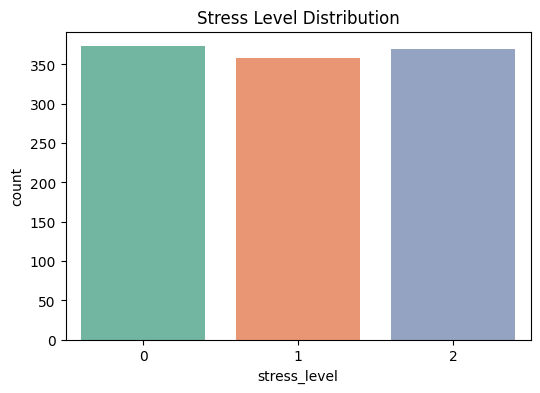

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='stress_level', data=df, palette='Set2')
plt.title("Stress Level Distribution")
plt.show()

**# Correlation Heatmap**

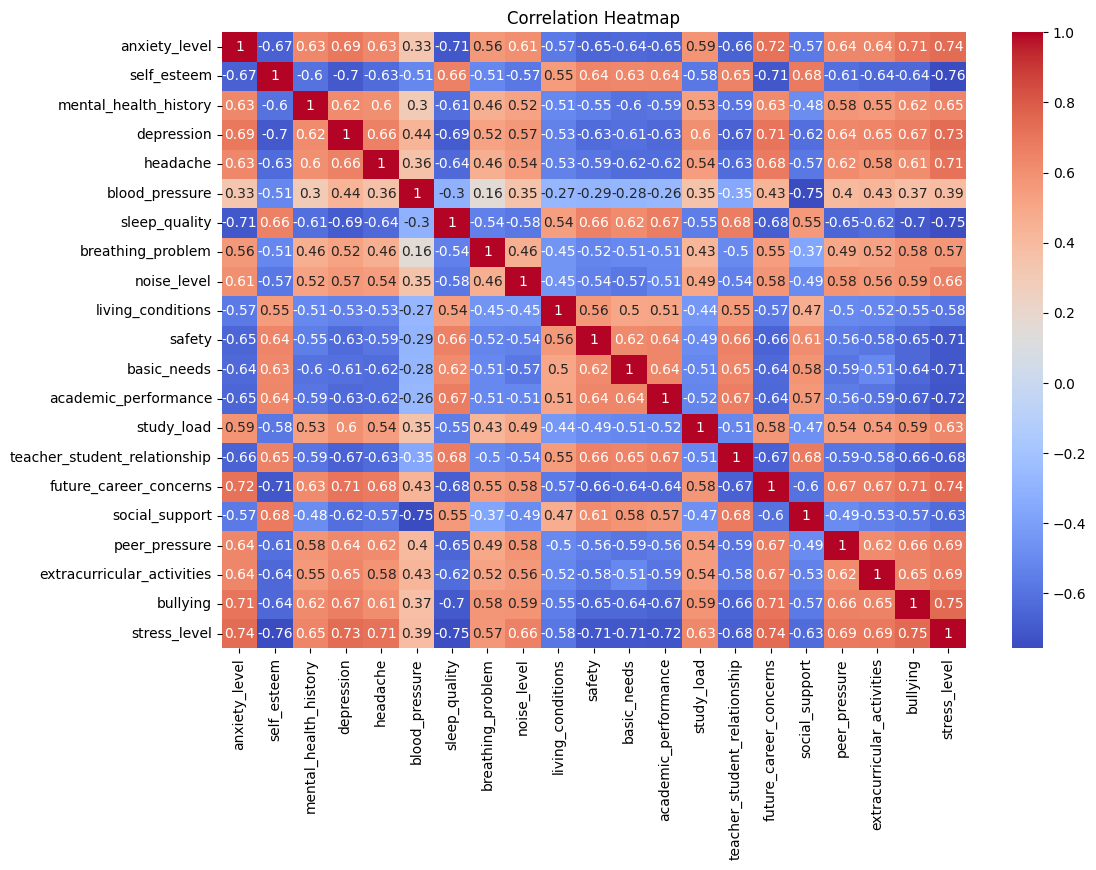

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

**Boxplots of features vs stress_level**

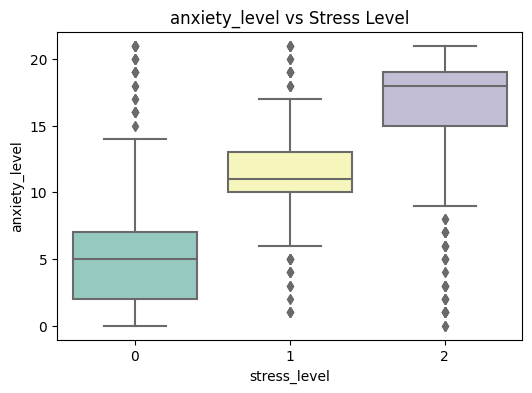

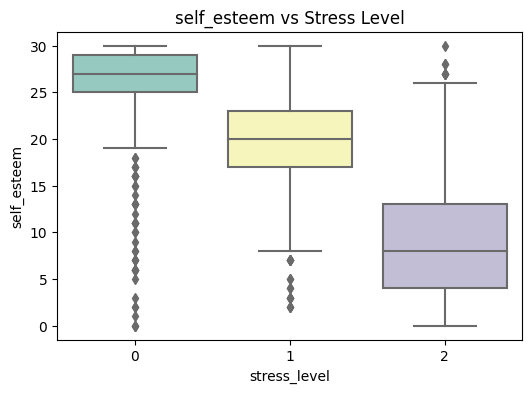

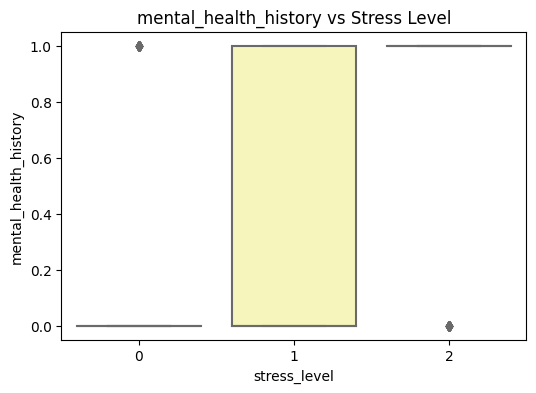

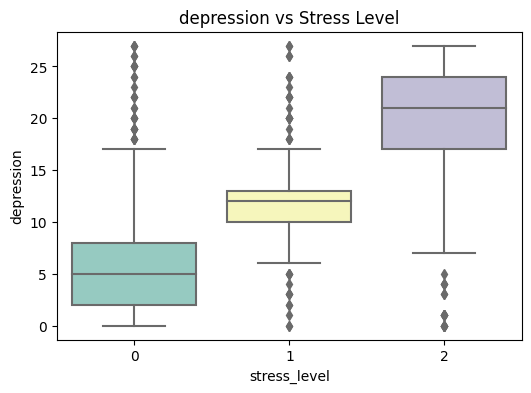

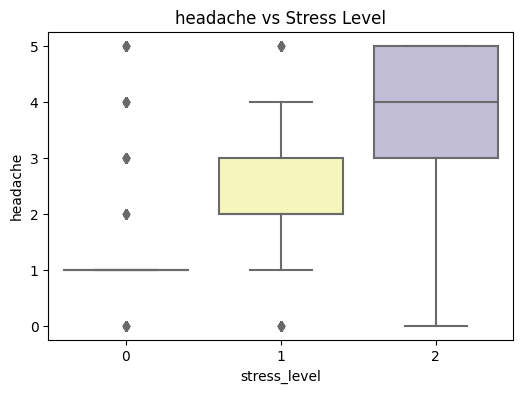

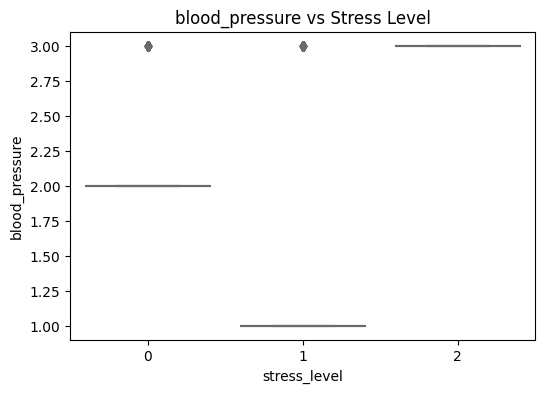

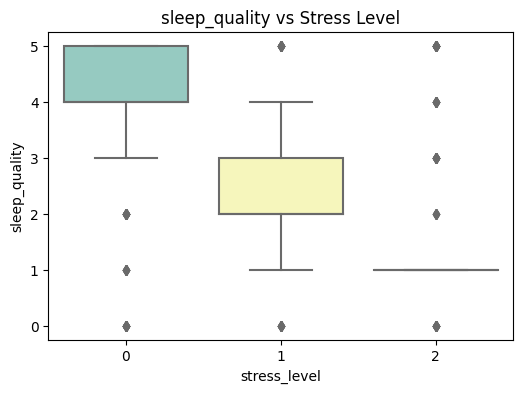

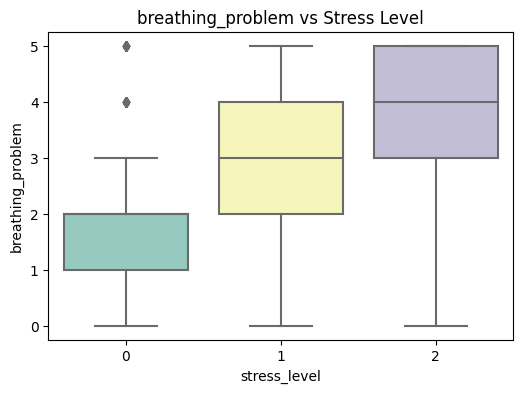

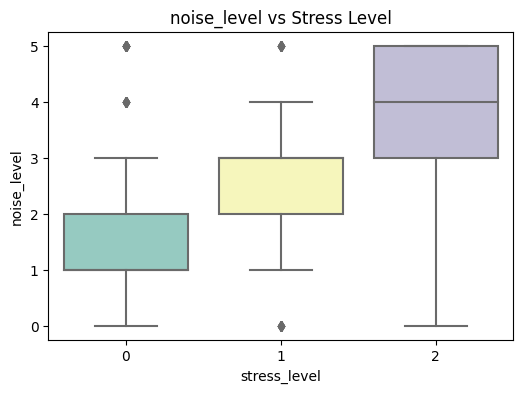

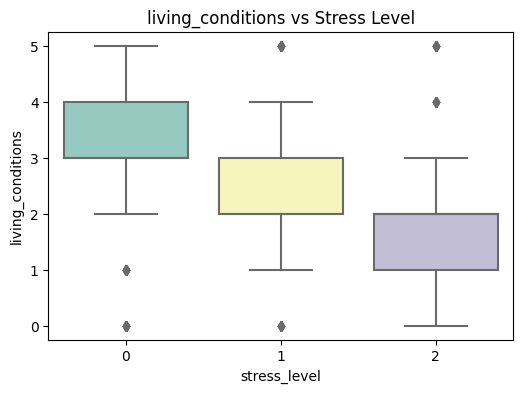

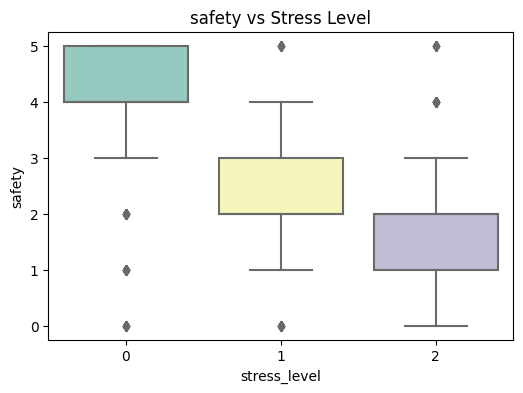

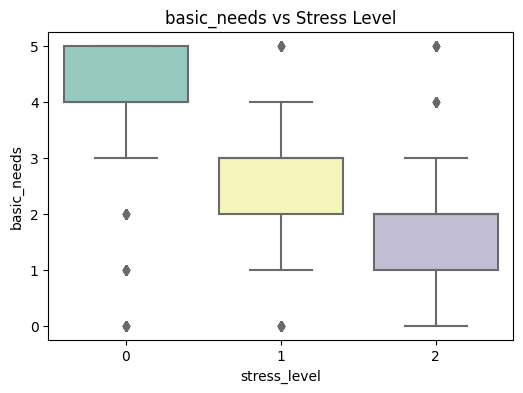

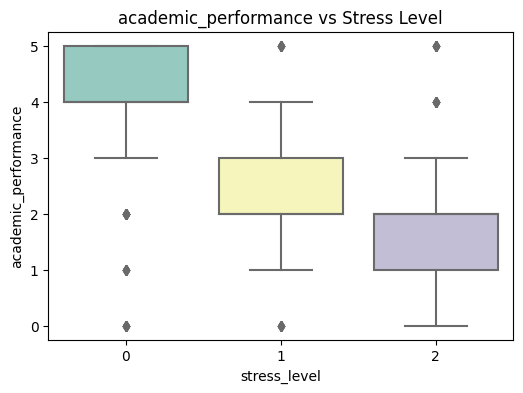

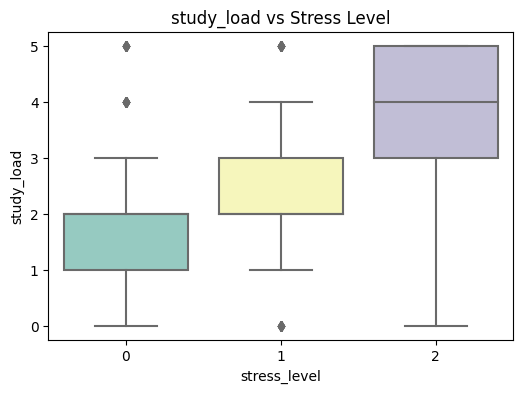

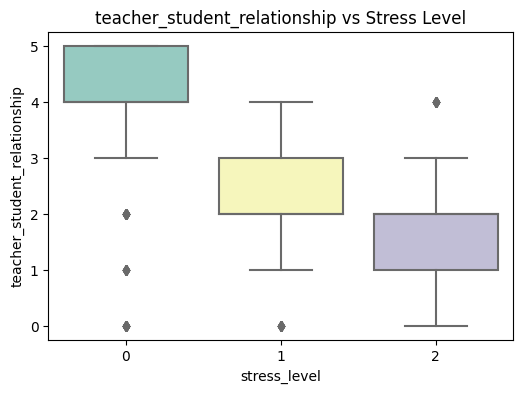

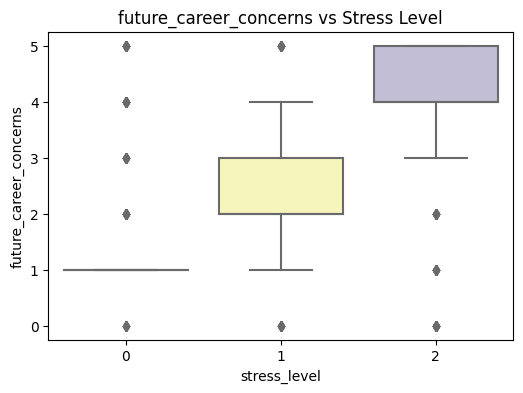

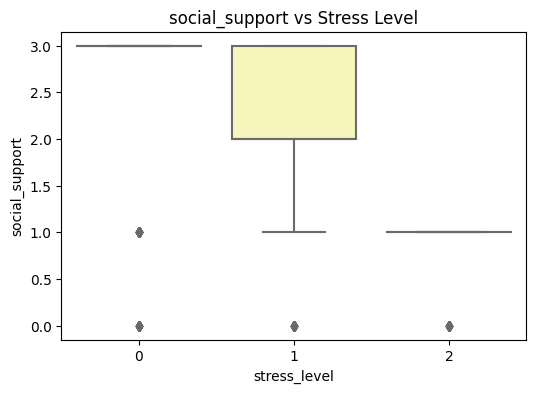

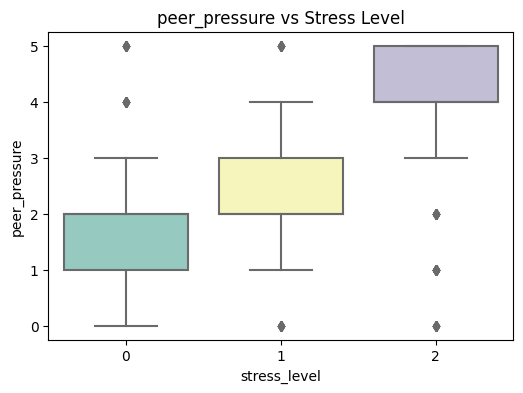

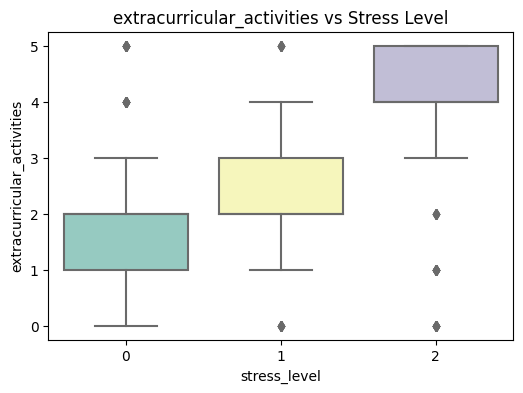

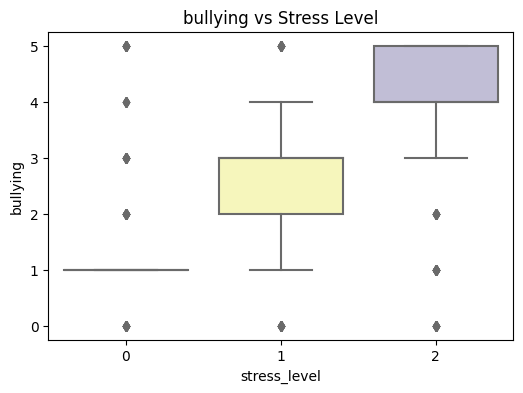

In [9]:
for col in df.drop("stress_level", axis=1).columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="stress_level", y=col, data=df, palette="Set3")
    plt.title(f"{col} vs Stress Level")
    plt.show()

**Step 4: Feature Engineering**

In [10]:
df_fe = df.copy()
df_fe["bp_sleep_ratio"] = df_fe["blood_pressure"] / (df_fe["sleep_quality"] + 1)
df_fe["mental_health_sum"] = df_fe["anxiety_level"] + df_fe["depression"]
df_fe["academic_pressure"] = df_fe["study_load"] + df_fe["academic_performance"]
df_fe["environment_index"] = df_fe["noise_level"] + df_fe["living_conditions"] + df_fe["safety"]
df_fe["social_factor"] = df_fe["peer_pressure"] - df_fe["social_support"]
df_fe["headache_breathing"] = df_fe["headache"] * df_fe["breathing_problem"]
print("New columns added:", set(df_fe.columns) - set(df.columns))
df_fe.head()

New columns added: {'academic_pressure', 'bp_sleep_ratio', 'environment_index', 'social_factor', 'headache_breathing', 'mental_health_sum'}


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,peer_pressure,extracurricular_activities,bullying,stress_level,bp_sleep_ratio,mental_health_sum,academic_pressure,environment_index,social_factor,headache_breathing
0,14,20,0,11,2,1,2,4,2,3,...,3,3,2,1,0.333333,25,5,8,1,8
1,15,8,1,15,5,3,1,4,3,1,...,4,5,5,2,1.500000,30,5,6,3,20
2,12,18,1,14,2,1,2,2,2,2,...,3,2,2,1,0.333333,26,5,7,1,4
3,16,12,1,15,4,3,1,3,4,2,...,4,4,5,2,1.500000,31,6,8,3,12
4,16,28,0,7,2,3,5,1,3,2,...,5,0,5,1,0.500000,23,7,9,4,2


**Step 5: Target & Features and Train-Test Split**

In [11]:
X = df_fe.drop("stress_level", axis=1)
y = df_fe["stress_level"]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

**Step 6: Preprocessing Pipeline**

In [12]:
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if X[c].dtype != "object"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])

**Step 7: Define Models**

In [13]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "ExtraTrees": ExtraTreesClassifier(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, random_state=RANDOM_STATE)
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

**Step 8: Train & Evaluate for Untuned Models**

In [14]:
results = {}
print("\nUntuned Models Accuracies: ")
print("\n")
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

best_untuned_name = max(results, key=results.get)
best_untuned_model = pipelines[best_untuned_name]
print("\nBest Untuned Model:", best_untuned_name, "Accuracy:", f"{results[best_untuned_name]:.4f}")


Untuned Models Accuracies: 


LogisticRegression Accuracy: 0.8818
SVC Accuracy: 0.8727
KNN Accuracy: 0.8591
GaussianNB Accuracy: 0.8727
DecisionTree Accuracy: 0.8864
RandomForest Accuracy: 0.9091
ExtraTrees Accuracy: 0.8864
GradientBoosting Accuracy: 0.8773
AdaBoost Accuracy: 0.8909
XGBoost Accuracy: 0.8682

Best Untuned Model: RandomForest Accuracy: 0.9091


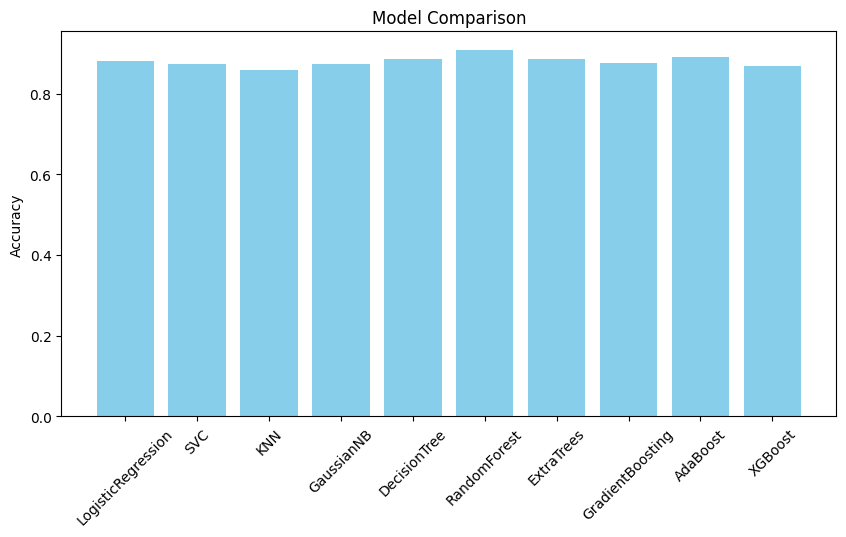

In [15]:
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

**ROC Curves for Untuned Models**

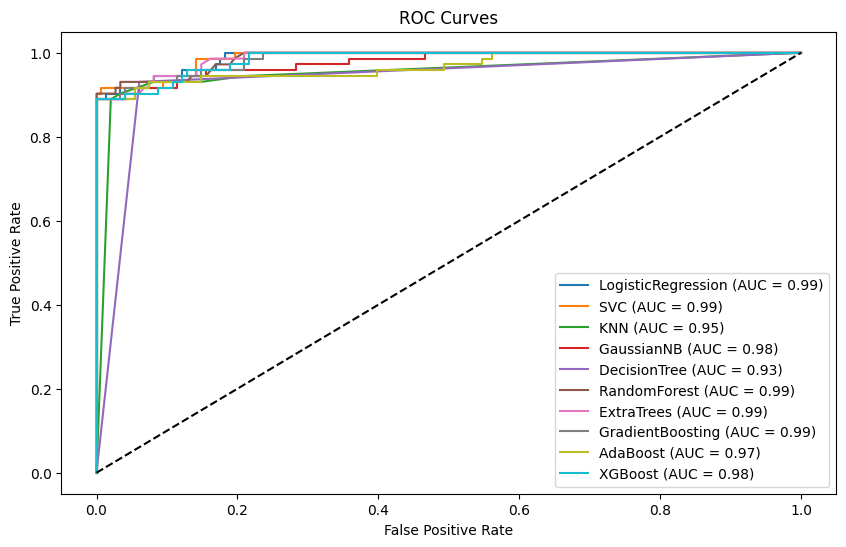

In [16]:
plt.figure(figsize=(10,6))
for name, pipeline in pipelines.items():
    if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
        y_score = pipeline.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

**Confusion Matrix & Report for best Untuned Model**


Classification Report ( RandomForest ):
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        74
           1       0.91      0.93      0.92        72
           2       0.89      0.92      0.91        74

    accuracy                           0.91       220
   macro avg       0.91      0.91      0.91       220
weighted avg       0.91      0.91      0.91       220



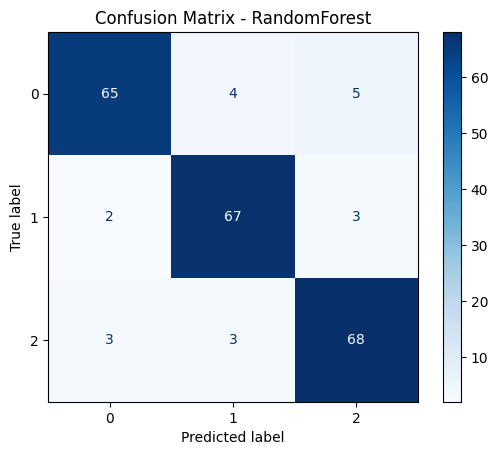

In [17]:
y_pred_best = best_untuned_model.predict(X_test)
print("\nClassification Report (", best_untuned_name, "):")
print(classification_report(y_test, y_pred_best))
ConfusionMatrixDisplay.from_estimator(best_untuned_model, X_test, y_test, cmap="Blues")
plt.title(f"Confusion Matrix - {best_untuned_name}")
plt.show()

**Step 9: Hyperparameter Tuning**

In [18]:
param_grid = {
    "LogisticRegression": {
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ["l2"],
        "classifier__solver": ["lbfgs"]
    },
    "SVC": {
        "classifier__C": [0.1, 1, 10],
        "classifier__kernel": ["linear", "rbf", "poly"],
        "classifier__gamma": ["scale", "auto"]
    },
    "KNN": {
        "classifier__n_neighbors": [3, 5, 7, 9],
        "classifier__weights": ["uniform", "distance"],
        "classifier__metric": ["euclidean", "manhattan"]
    },
    "GaussianNB": {
        "classifier__var_smoothing": [1e-09, 1e-08, 1e-07]
    },
    "DecisionTree": {
        "classifier__max_depth": [None, 5, 10, 20],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4],
        "classifier__criterion": ["gini", "entropy"]
    },
    "RandomForest": {
        "classifier__n_estimators": [100, 200, 300],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2],
        "classifier__criterion": ["gini", "entropy"]
    },
    "ExtraTrees": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [None, 10, 20],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2],
        "classifier__criterion": ["gini", "entropy"]
    },
    "GradientBoosting": {
        "classifier__n_estimators": [100, 200],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__max_depth": [3, 5, 7],
        "classifier__subsample": [0.8, 1.0]
    },
    "AdaBoost": {
        "classifier__n_estimators": [50, 100, 200],
        "classifier__learning_rate": [0.01, 0.1, 1]
    },
    "XGBoost": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 5, 7],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__subsample": [0.8, 1.0],
        "classifier__colsample_bytree": [0.8, 1.0]
    }
}


**Train & Evaluate for Tuned Models**

In [19]:
tuned_results = {}
best_tuned_models = {}
print("\nTuned Models Accuracies: ")
for name, pipeline in pipelines.items():
    if name in param_grid:
        grid = GridSearchCV(pipeline, param_grid[name], cv=3, scoring="accuracy", n_jobs=-1)
        grid.fit(X_train, y_train)
        best_tuned_models[name] = grid.best_estimator_
        y_pred = grid.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        tuned_results[name] = acc
        print(f"{name} Accuracy: {acc:.4f}") 

best_tuned_name = max(tuned_results, key=tuned_results.get)
best_tuned_model = best_tuned_models[best_tuned_name]
print(f"\nBest Tuned Model: {best_tuned_name} Accuracy: {tuned_results[best_tuned_name]:.4f}")


Tuned Models Accuracies: 
LogisticRegression Accuracy: 0.8818
SVC Accuracy: 0.8864
KNN Accuracy: 0.8636
GaussianNB Accuracy: 0.8727
DecisionTree Accuracy: 0.8909
RandomForest Accuracy: 0.8727
ExtraTrees Accuracy: 0.8909
GradientBoosting Accuracy: 0.8955
AdaBoost Accuracy: 0.8909
XGBoost Accuracy: 0.8864

Best Tuned Model: GradientBoosting Accuracy: 0.8955


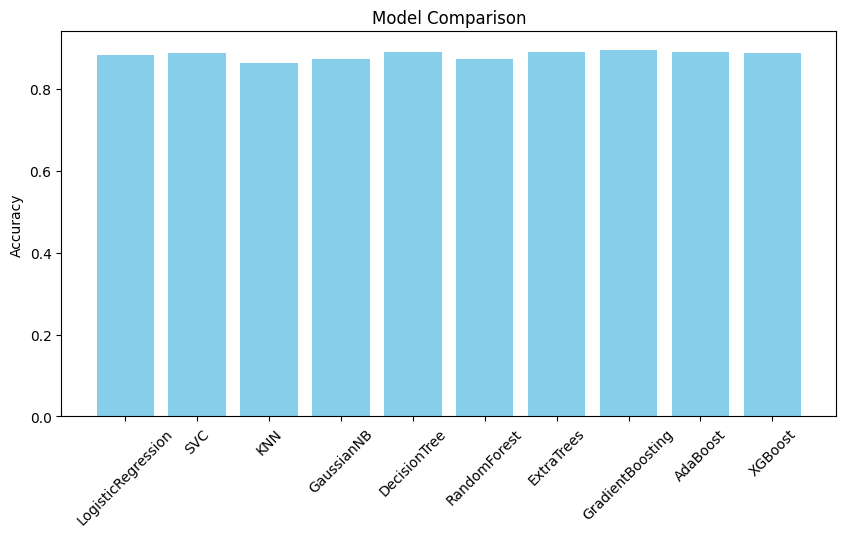

In [20]:
plt.figure(figsize=(10, 5))
plt.bar(tuned_results.keys(), tuned_results.values(), color="skyblue")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

**ROC Curves for Tuned Models**

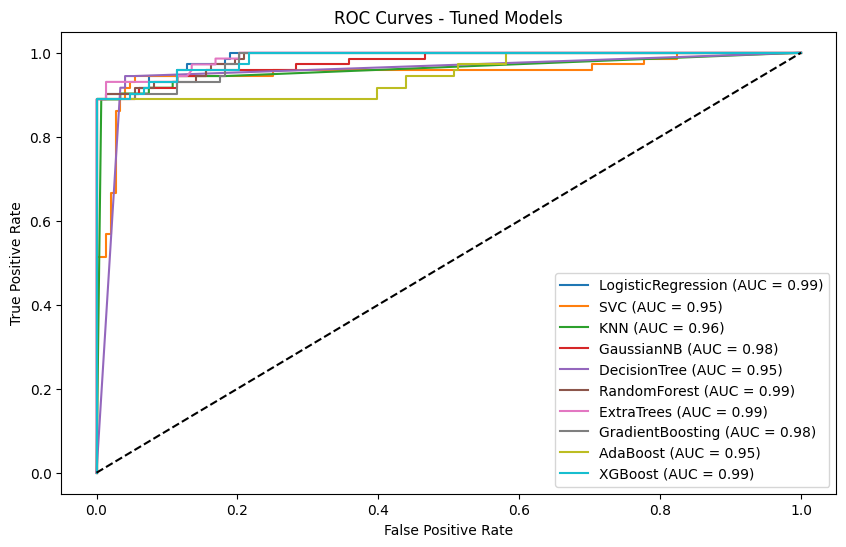

In [21]:
plt.figure(figsize=(10,6))
for name, model in best_tuned_models.items():
    if hasattr(model.named_steps["classifier"], "predict_proba"):
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:,1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Tuned Models")
plt.legend()
plt.show()

**Confusion Matrix & Report for best Tuned Model**


Classification Report (GradientBoosting):
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        74
           1       0.89      0.90      0.90        72
           2       0.87      0.91      0.89        74

    accuracy                           0.90       220
   macro avg       0.90      0.90      0.90       220
weighted avg       0.90      0.90      0.90       220



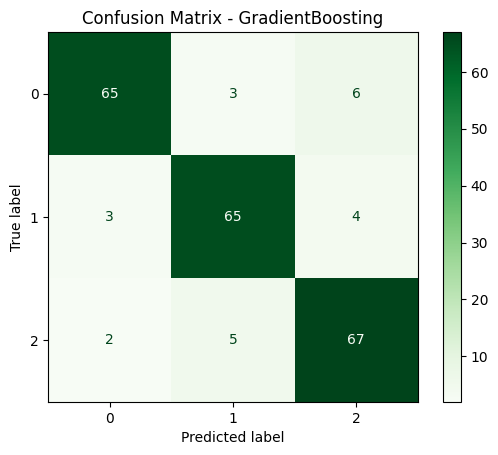

In [22]:
y_pred_best_tuned = best_tuned_model.predict(X_test)
print(f"\nClassification Report ({best_tuned_name}):")
print(classification_report(y_test, y_pred_best_tuned))

ConfusionMatrixDisplay.from_estimator(best_tuned_model, X_test, y_test, cmap="Greens")
plt.title(f"Confusion Matrix - {best_tuned_name}")
plt.show()

**Step 10: Accuracy Comparison**

In [23]:
df_compare = pd.DataFrame({
    "Untuned Models": results,
    "Tuned Models": tuned_results
}).fillna("-")
df_compare

,Untuned Models,Tuned Models
LogisticRegression,0.881818,0.881818
SVC,0.872727,0.886364
KNN,0.859091,0.863636
GaussianNB,0.872727,0.872727
DecisionTree,0.886364,0.890909
RandomForest,0.909091,0.872727
ExtraTrees,0.886364,0.890909
GradientBoosting,0.877273,0.895455
AdaBoost,0.890909,0.890909
XGBoost,0.868182,0.886364


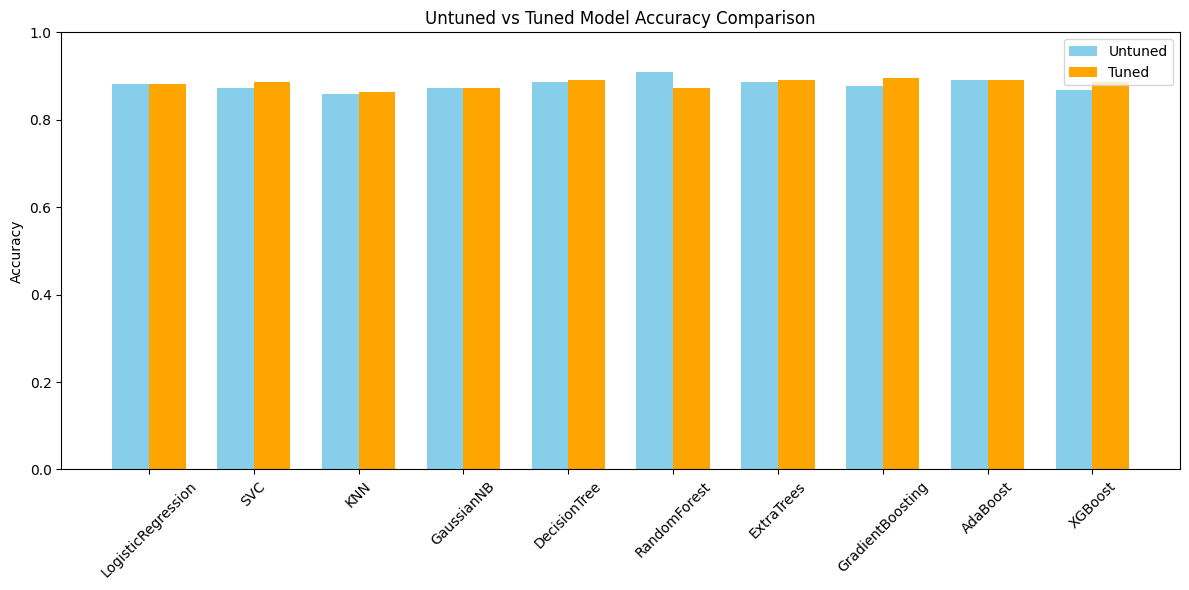

In [24]:
df_plot = df_compare.replace("-", 0).astype(float)
models = df_plot.index
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, df_plot["Untuned Models"], width, label="Untuned", color="skyblue")
plt.bar(x + width/2, df_plot["Tuned Models"], width, label="Tuned", color="orange")

plt.xticks(x, models, rotation=45)
plt.ylabel("Accuracy")
plt.title("Untuned vs Tuned Model Accuracy Comparison")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

**Step 11: Prediction**

In [25]:
pred_df = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    f"Untuned_Best ({best_untuned_name})": y_pred_best,
    f"Tuned_Best ({best_tuned_name})": y_pred_best_tuned
})
pred_df.head(10)

,Actual,Untuned_Best (RandomForest),Tuned_Best (GradientBoosting)
0,0,0,0
1,0,0,0
2,2,2,2
3,2,2,2
4,0,2,2
5,0,0,0
6,2,2,2
7,0,0,2
8,1,1,1
9,0,2,0
